<h1>Sentiment Analysis of 'Squid Game' reviews using VADER, Naive Bayes Classifier and LSTM</h1>
<h3>Viktoriia Ilina</h3>
<h3>November 2021</h3>

<h2>Overview</h2>

‘[Squid Game](https://www.netflix.com/pl/title/81040344/)’, violent and disturbing survival drama, debuted across the globe on September 17 and quickly took the world by storm. Two weeks after release, [series was ranked #1 on Netflix](https://www.sportskeeda.com/pop-culture/why-squid-game-popular-the-rise-global-phenomenon-explained/) in each of the 83 countries where it was available. [On November 14](https://www.cnet.com/news/netflix-squid-game-is-even-bigger-than-you-thought-2-billion-hours-big/), Netflix subscribers collectively watched 2.1 billion total hours of ‘Squid Game’, that was more watched than anything else Netflix has released. The series has the average [rating](https://www.imdb.com/title/tt10919420/ratings/?ref_=tt_ov_rt/) 8.1 based on votes of more than 314,000 IMDb users. Some users sing the praises of director, others write that ‘Squid Game’ is the extremely overhyped and overrated series. Most likely, truth lies somewhere in-between. 

In this notebook, we try to predict the positive or negative sentiment of the reviews using three different algorithms: 1) Rule-based analyzer - VADER, 2) Naive Bayes Classifier, and 3) Long short-term memory. The initial idea was to extract data from ‘[Rotten tomatoes](https://www.rottentomatoes.com/tv/squid_game/s01/reviews?type=user/)’ only, but in the end we got an imbalanced dataset with a strong bias towards positive reviews. Most machine learning/deep learning classification algorithms aren’t equipped to handle imbalanced classes and tend to get biased towards majority classes. There are a lot of methods to fix it, but most of them doesn’t work well for text data (for instance, SMOTE). We found an interesting [idea](https://towardsdatascience.com/how-i-handled-imbalanced-text-data-ba9b757ab1d8/) used in Kaggle competition – convert English text to any random language and converting back to English using neutral machine translation. However, we decided to solve our problem in the most trivial way and extract missing negative reviews from [IMDb](https://www.imdb.com/title/tt10919420/reviews/). IMDb rating scale was adjusted in compliance with ‘Rotten tomatoes’.

<h2>Exploratory data analysis</h2>

To begin with, let's take a quick look at the data. As we can see, dataset contains 1100 observations and four attributes:
- date;
- user name;
- user review;
- user rating. 

In [2]:
#Installation and importing all necessary libraries 
!pip install pandas
import pandas as pd
!pip install matplotlib
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
!pip install wordcloud
import wordcloud
from wordcloud import WordCloud,STOPWORDS
!pip install nltk
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
!pip install sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
!pip install tensorflow==2.5.0
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/wsuser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Loading data
filepath = 'https://github.com/Viktoriia-Ilina/Sentiment-Analysis-of-Squid-Game-reviews-using-VADER-Naive-Bayes-Classifier-and-LSTM/blob/main/reviews_balanced.xlsx?raw=true'
data = pd.read_excel(filepath)
data

The maximum number of reviews were written approximately two week after release, while the least number - in mid-November (almost two months after series came out).

In [74]:
data['Date'].value_counts()

2021-10-03    40
2021-10-05    35
2021-10-10    35
2021-10-02    34
2021-10-12    33
              ..
2021-11-14     4
2021-11-17     3
2021-11-10     2
2021-11-18     1
2021-11-20     1
Name: Date, Length: 65, dtype: int64

The average length of the review is 309 symbols, but we observe very high standard deviation here - 420. It is therefore not surprising that the longest review has more than 7300 symbols, the shortest – 13 symbols only.

In [75]:
lens = data['Review'].str.len()
print('The average length of the review:', lens.mean())
print('Standard deviation of length:', lens.std())
print('Minimum length of the review:', lens.min())
print('Maximum length of the review:', lens.max())

The average length of the review: 309.64272727272726
Standard deviation of length: 420.1741575222304
Minimum length of the review: 13
Maximum length of the review: 7381


For further analysis, we create a new column 'Sentiment' based on overall ratings.

In [76]:
def sentiments(data):
  if data['Rating'] > 3.0:
    return 'Positive'
  elif data['Rating'] <= 3.0:
    return 'Negative'
data['Sentiment'] = data.apply(sentiments, axis=1)

As can be seen from the chart below, the dataset is pretty balanced. It's not surprising, taking into account features of its formation referred to in the overview.

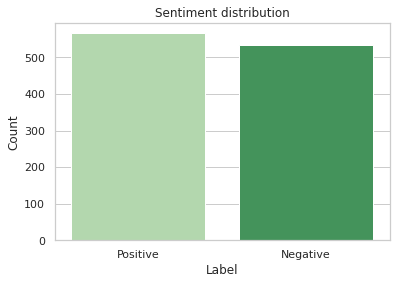

In [77]:
sns.set(style = 'whitegrid')
dist = sns.countplot(x = 'Sentiment', data = data, palette = 'Greens')
dist.axes.set_title('Sentiment distribution')
dist.set_xlabel('Label')
dist.set_ylabel('Count')
plt.show()

Next, we visualize the wordclouds for sentences with positive and negative sentiment. You can see that for positive sentiment there are such words as 'great', 'well', 'good', 'amazing', 'best', 'entertaining' and so on. For the negative sentiment we can see words 'overrated', 'predictable', 'boring', 'overhyped', 'bad', etc. It's interesting that one of the most common words among negative sample is 'good'. The answer lies in the nature of WordCloud algoritm: we remove stop words from the sample, so we are losing context, and, as a result, 'not good' turns 'good'.

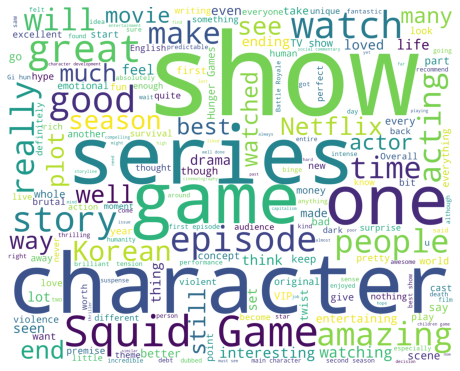

In [29]:
data_pos = data[ data['Sentiment'] == 'Positive']
data_pos = data_pos['Review']
wordcloud1 = WordCloud(stopwords = STOPWORDS, 
                       background_color = 'white', 
                       width = 2500, 
                       height = 2000 
                       ).generate(" ".join(data_pos))
plt.figure(1, figsize = (8, 8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

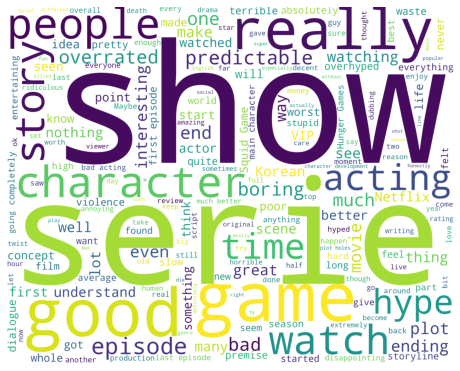

In [27]:
data_neg = data[ data['Sentiment'] == 'Negative']
data_neg = data_neg['Review']
wordcloud2 = WordCloud(stopwords = STOPWORDS,
                       background_color = 'white', 
                       width = 2500, 
                       height = 2000
                       ).generate(" ".join(data_neg))
plt.figure(1, figsize = (8, 8))
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

And now let us move on to modeling.

<h2>Methodology and analysis</h2>

<h3>VADER</h3>

We begin with popular rule-based sentiment analyzer – [VADER](https://www.researchgate.net/publication/275828927_VADER_A_Parsimonious_Rule-based_Model_for_Sentiment_Analysis_of_Social_Media_Text/) (Valence Aware Dictionary and sEntiment Reasoner). This tool is deliberately harnessed to sentiments expressed in social media, which is generally full of colloquial and informal expressions, emotional abbreviated expressions and finally emojis common for social media posts.

The lexicon approach implies an algorithm building up a dictionary, which is a comprehensive word index of sentiment features. All the features were rated by 10 independent human graders in terms of polarity and intensity to a scale between ‘-4: Extremely Negative’ and ‘+4 Extremely Positive’, and then marked in the dictionary by average score. The word ‘rejoice’, for example, is rated +2.0, the word ‘tragedy’ is alleged highly negative and rated -3.4, and the ‘:(‘ frowning emotion rated -2.2. In total, VADER’s lexicon dictionary counts around 7,500 sentiment features. Any word not found in the base scores 0, which means ‘neutral’. Some originally neutral structures, like ‘not’ or ‘but’, may invert the sentiment’s polarity, or alternate the entire intensity of a sentence, as it happens with the words ‘very’ or ‘extremely’. VADER’s developers also implement a dedicated set of heuristic rules, that maintain the matters of contrastive conjunctions, adverbs, punctuation, capitalization, and so on.

For sentimental scoring of a text in the whole, VADER examines the text for defined familiar features, adjusts the intensity to the rules, calculates the score of detected features and generalizes the final score to (-1, 1). After that, the unit is labeled based on this information.

Important nuance: VADER requires no training data. 

In [66]:
vader = data.copy()

sia = SentimentIntensityAnalyzer()

vader['Scores'] = vader['Review'].apply(lambda Text: sia.polarity_scores(Text))
vader['Compound']  = vader['Scores'].apply(lambda score_dict: score_dict['compound'])
vader['VADER'] = vader['Compound'].apply(lambda c: 'Positive' if c >=0 else 'Negative')

vader = vader.drop(['Date', 'User', 'Scores', 'Compound'], axis=1)

vader

,Review,Rating,Sentiment,VADER
0,It quite disturbing and bloodshed for people i...,3.5,Positive,Negative
1,I'm just finished Squid Game and it deserves p...,4.5,Positive,Positive
2,Aside from being stretched just a touch too th...,4.0,Positive,Positive
3,"I'm giving it 4 stars for the themes, producti...",4.0,Positive,Positive
4,Surprisingly entertaining fantasy. Don't be la...,5.0,Positive,Positive
...,...,...,...,...
1095,Too slow... I watched the first three episodes...,1.0,Negative,Positive
1096,This show is so predictable that I was angry a...,1.0,Negative,Negative
1097,So overrated. Is it realistic? This game inven...,1.0,Negative,Negative
1098,Depressing and predictable. This show started ...,1.0,Negative,Negative


We got an accuracy score of 71%. That sounds not bad, but lots of negative reviews were misclassified. One explanation for this result is the approach evaluates individual words only and ignores the context in which they are used. As a consequence, this often leads to errors, particularly for sarcasm and irony. 

In [67]:
print(classification_report(vader['Sentiment'], vader['VADER']))

              precision    recall  f1-score   support

    Negative       0.79      0.56      0.65       534
    Positive       0.67      0.86      0.76       566

    accuracy                           0.71      1100
   macro avg       0.73      0.71      0.71      1100
weighted avg       0.73      0.71      0.71      1100



<h3>Naive Bayes</h3>

Now, we try to classify reviews using the multinomial Naive Bayes technique. This method uses conditional probabilities of each lexical feature occurring in either positive or negative text in the training data to arrive at the outcome.

However, we can’t feed raw data directly to the algorithm, because technique works with numerical features only. So, we must extract numerical features from text content. 

Thus, for beginning, we preprocess the reviews by excluding the special characters, digits, unnecessary symbols, and stop words and convert them to lowercase. For text normalization we use [stemming](https://towardsdatascience.com/stemming-corpus-with-nltk-7a6a6d02d3e5/). It helps us to standardize words that share the same suffix and that normally are derivations of gramatically similar words.

In [68]:
#Coping initial dataset
naive = data.copy()

#Converting all characters to lowercase
naive['Review'] = naive['Review'].str.lower()

#Removing digits
naive['Review'] = naive['Review'].str.replace('\d+', '')

#Removing punctuation symbols
naive['Review'] = naive['Review'].str.replace('[^\w\s]','')

#Removing stop words
nltk.download('stopwords')
stop = stopwords.words('english')
naive['Review'] = naive['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#Stemming
snowball = SnowballStemmer(language = 'english')

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [snowball.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

naive['Review'] = naive['Review'].apply(stem_sentences)

#Dropping unnecessary columns
naive = naive.drop(['Date', 'User'], axis=1)

naive

<ipython-input-68-104bcbac98f7>:8: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-68-104bcbac98f7>:11: FutureWarning:

The default value of regex will change from True to False in a future version.

[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Review,Rating,Sentiment
0,quit disturb bloodsh peopl young agesyou guy p...,3.5,Positive
1,im finish squid game deserv prais alot charact...,4.5,Positive
2,asid stretch touch thin spot id say squid game...,4.0,Positive
3,im give star theme product design cinematograp...,4.0,Positive
4,surpris entertain fantasi dont lazi make sure ...,5.0,Positive
...,...,...,...
1095,slow watch first three episod fast forward lot...,1.0,Negative
1096,show predict angri wast hour account year imdb...,1.0,Negative
1097,overr realist game invent everi year mani peop...,1.0,Negative
1098,depress predict show start interest end let ch...,1.0,Negative


After this, we encode the sentiments using ‘Label encoder’. 

In [69]:
lb = LabelEncoder()
naive['Sentiment'] = lb.fit_transform(naive['Sentiment'])

Here, we divide the dataset into training and testing sets (90/10). 

In [70]:
X = naive['Review']
y = naive['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 101)

Afterwards, we extract numerical features from text content. We use parameter min_df = 2 to filter out words that occur only once in the entire dataset. 

In [71]:
vectorizer = TfidfVectorizer(min_df = 2)
train_term = vectorizer.fit_transform(X_train)
test_term = vectorizer.transform(X_test)

In the next cell, we train the model. After we get the predictions of this model on the training and testing data set and measure the accuracy. We can see that the accuracy on the test set is really high - 90%. Confusion matrix shows that there are 7 test examples with positive sentiment which model classified as negative sentiment and 4 examples with negative sentiment which model classified as positive label.

In [72]:
model = MultinomialNB(alpha = 3)
model.fit(train_term, y_train)
predictions_train = model.predict(train_term)
predictions_test = model.predict(test_term)
print('Train Accuracy:', accuracy_score(y_train, predictions_train))
print('Test Accuracy:', accuracy_score(y_test, predictions_test))
print(confusion_matrix(y_test, predictions_test))

Train Accuracy: 0.9303030303030303
Test Accuracy: 0.9
[[46  4]
 [ 7 53]]


Certainly we tried to improve the result working on vectorization and text normalization. We noticed the following things:

1. PorterStemmer didn't change the accuracy.
2. Lemmatization reduced the accuracy to 0.8818(TfidfVectorizer) or even 0.8636(CountVectorizer).
3. The performance of the model trained after CountVectorizer was lower (0.8909).

<h3>LSTM</h3>

Finally, we try to solve our problem using a deep learning algorithm LSTM (Long Short Term Memory). [LSTM](https://aclanthology.org/O18-1021.pdf/) is used for learning long-distance dependency between word sequence in short texts. The final output from the last point of time is used as the prediction result.

We again preprocess our data and label reviews.

In [78]:
#Coping initial dataset
lstm = data.copy()

#Converting all characters to lowercase
lstm['Review'] = lstm['Review'].str.lower()

#Removing digits
lstm['Review'] = lstm['Review'].str.replace('\d+', '')

#Removing punctuation symbols
lstm['Review'] = lstm['Review'].str.replace('[^\w\s]','')

#Removing stop words
stop = stopwords.words('english')
lstm['Review'] = lstm['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#Stemming
snowball = SnowballStemmer(language = 'english')

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [snowball.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

lstm['Review'] = lstm['Review'].apply(stem_sentences)

#Dropping unnecessary columns
lstm = lstm.drop(['Date', 'User'], axis=1)

#Labelling data
lb = LabelEncoder()
lstm['Sentiment'] = lb.fit_transform(lstm['Sentiment'])

lstm

,Review,Rating,Sentiment
0,quit disturb bloodsh peopl young agesyou guy p...,3.5,1
1,im finish squid game deserv prais alot charact...,4.5,1
2,asid stretch touch thin spot id say squid game...,4.0,1
3,im give star theme product design cinematograp...,4.0,1
4,surpris entertain fantasi dont lazi make sure ...,5.0,1
...,...,...,...
1095,slow watch first three episod fast forward lot...,1.0,0
1096,show predict angri wast hour account year imdb...,1.0,0
1097,overr realist game invent everi year mani peop...,1.0,0
1098,depress predict show start interest end let ch...,1.0,0


Now, we tokenize and convert the reviews into numerical vectors. We set num_words to 1000. This means that the tokenizer detects the 1000 most frequent words from the dataset and use them as features for further model building. 

In [5]:
tokenizer = Tokenizer(num_words = 1000, split=' ') 
tokenizer.fit_on_texts(lstm['Review'].values)
X = tokenizer.texts_to_sequences(lstm['Review'].values)
X = pad_sequences(X)

Here we build our model. First, we initialize the sequence model. Then, we add word embedding layer that uses 100 length vectors to represent each word. SpatialDropout1D performs variational dropout in NLP models. The next layer is the LSTM layer with 136 memory units. The output layer must create 2 output values, one for each class. We use softmax activation function. Because it is a binary classification problem, binary_crossentropy is used as the loss function. To optimize the weights in each level, we use Adam optimizer. Also, we set accuracy as the metric for measuring model's performance.

In [6]:
model = Sequential()
model.add(Embedding(1000, 100, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(136, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation = 'softmax'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 487, 100)          100000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 487, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 136)               128928    
_________________________________________________________________
dense (Dense)                (None, 2)                 274       
Total params: 229,202
Trainable params: 229,202
Non-trainable params: 0
_________________________________________________________________
None


Let's split data into train and test sets (90/10) and then train the model.

In [7]:
y = pd.get_dummies(lstm['Sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 101)
model.fit(X_train, y_train, epochs = 5, batch_size = 32, verbose = 'auto')

Epoch 1/5
31/31 [==============================] - 76s 2s/step - loss: 0.6755 - accuracy: 0.5970
Epoch 2/5
31/31 [==============================] - 74s 2s/step - loss: 0.5773 - accuracy: 0.7182
Epoch 3/5
31/31 [==============================] - 74s 2s/step - loss: 0.4016 - accuracy: 0.8505
Epoch 4/5
31/31 [==============================] - 73s 2s/step - loss: 0.2389 - accuracy: 0.9061
Epoch 5/5
31/31 [==============================] - 72s 2s/step - loss: 0.1753 - accuracy: 0.9303


We get 86.36% accuracy and loss of 0.4386.

In [8]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 1s 285ms/step - loss: 0.4386 - accuracy: 0.8636


[0.43863019347190857, 0.8636363744735718]

The greatest obstacle to tuning hyperparamers for LSTM algorithm is the time to compute, therefore we can't use Grid Search or Random Search here, but we tested several hypotheses manually:
- Decreasing num_words to 500 reduces the accuracy to 85.45%.
- Using lemmatization instead of stemming decreases the accuracy dramatically(82.73%).
- Further increase in the number of memory cells doesn't lead to higher accuracy(83.64% with LSTM(176)).
- Increasing batch size to 64 impairs the performance significantly (to just 0.7636 accuracy score).
- Increasing the number of epoch downgrade the performance (85.45% with epoch = 7).

<h2>Conclusion</h2>

The main goal of our project was trying to predict the positive or negative sentiment of the reviews using three different algorithms: 1) Rule-based analyzer - VADER, 2) Naive Bayes Classifier, and 3) Long short-term memory. VADER is a fast and easy-to-implement algorithm, but suffering on exactness. Algorithm obtained an accuracy of 71%. One explanation for this result is the approach evaluates individual words only and ignores the context in which they are used. As a consequence, this often leads to errors, particularly for sarcasm and irony. Deep learning algorithm (LSTM) showed very high accuracy rate 86.36%, though model interpretability is in question. Additionally, it is the most expensive approach in terms of the time to compute. Naive Bayes model had the best performance here (incredible 90%). This was made possible thanks to robust training data. Availability and completeness of data for training are required for the algorithm’s feasibility.